 Reference: https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb

In [5]:
import os
import random

import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np 
import cv2

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [6]:
filePath = '/home/shared/DARPA/patched_category/line/training/'

### Visualize the input data 

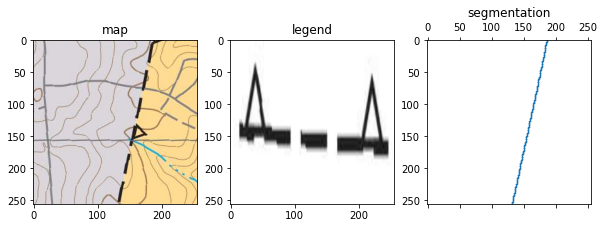

In [7]:
def plotMap(fileName):
    mapName = 'map_patches/'+fileName
    segName = 'seg_patches/'+fileName
    labelName = 'labels/'+fileName

    map_img = mpimg.imread(filePath+mapName)
    seg_img = mpimg.imread(filePath+segName)
    label_img = mpimg.imread(filePath+labelName)
    
    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(1,3,1)
    plt.title("map")
    plt.imshow(map_img)

    plt.subplot(1,3,2)
    plt.title("legend")
    plt.imshow(label_img) 
    
    plt.subplot(1,3,3)
    plt.title("segmentation")
    plt.spy(seg_img, markersize=0.5)
 
    plt.show()
    
plotMap('VA_Lahore_bm_thrust_fault_line_402.png')

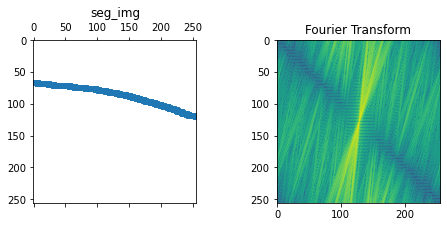

In [8]:
def plotFourier(fileName):
    segName = 'seg_patches/'+fileName
    seg_img = mpimg.imread(filePath+segName)
    
    dft = cv2.dft(seg_img, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

    plt.rcParams["figure.figsize"] = (8,3)
    plt.subplot(1,2,1)
    plt.title("seg_img")
    plt.spy(seg_img, markersize=5)

    plt.subplot(1,2,2)
    plt.title("Fourier Transform")
    plt.imshow(magnitude_spectrum) 
    plt.show()
    
plotFourier('CA_SantaMaria_fault_line_1382.png')


## create a datagenerator 

2022-10-07 09:08:00.536111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13870 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:05:00.0, compute capability: 7.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


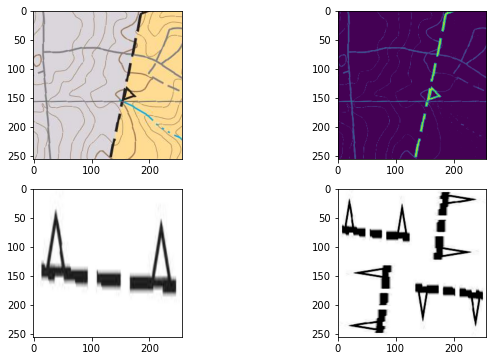

In [9]:
def load_img(filename):
    mapName = 'map_patches/'+filename
    legendName = 'labels/'+filename    

    map_img = tf.io.read_file(filePath+mapName) # Read image file
    map_img = tf.cast(tf.io.decode_png(map_img), dtype=tf.float32) / 255.0
    
    # edge detection to filter out lines
    kChannel = 1 - tf.reduce_max(map_img, axis=2) # Calculate channel K
    binaryThresh = 80/255
    binaryImage = tf.clip_by_value(kChannel, clip_value_min=binaryThresh, clip_value_max=1) # keep only black pixel
    binaryImage = 2.0*(binaryImage-binaryThresh)/(1.0-binaryThresh)-1.0
    binaryImage = tf.expand_dims(binaryImage, axis=-1)

    
    
    legend_img = tf.io.read_file(filePath+legendName) # Read image file
    legend_img = tf.cast(tf.io.decode_png(legend_img), dtype=tf.float32) / 255.0
    
    # rotate to create more legend
    resize_leg = tf.image.resize(legend_img, [128, 128])
    resize_leg_r1 = tf.image.rot90(resize_leg)
    resize_leg_r2 = tf.image.rot90(resize_leg,k=2)
    resize_leg_r3 = tf.image.rot90(resize_leg,k=3)

    col1 = tf.concat([resize_leg, resize_leg_r1],0)
    col2 = tf.concat([resize_leg_r3, resize_leg_r2],0)
    rotate = tf.concat([col1, col2],1)
    rotate = rotate*2.0 - 1.0 # range(-1.0,1.0)

    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(2,2,1)
    plt.imshow(map_img.numpy())
    plt.subplot(2,2,2)
    plt.imshow(binaryImage.numpy())
    plt.subplot(2,2,3)
    plt.imshow(legend_img.numpy())
    plt.subplot(2,2,4)
    plt.imshow(rotate.numpy())

    img = tf.concat(axis=2, values = [binaryImage, rotate])
    resize_image = tf.image.resize(img, [256, 256])
    
    segName = 'seg_patches/'+filename
    seg = tf.io.read_file(filePath+segName) # Read image file
    seg = tf.io.decode_png(seg)/255
    resize_seg = tf.image.resize(seg, [256, 256])
    
    return resize_image, resize_seg

img, seg = load_img('VA_Lahore_bm_thrust_fault_line_402.png')

In [24]:
filenames = os.listdir(filePath+'map_patches') 

In [25]:
train_file, validate_file = train_test_split(filenames, train_size=0.8, random_state=42)
len(train_file), len(validate_file), len(filenames)

train_dataset = tf.data.Dataset.from_tensor_slices(train_file)
train_dataset = train_dataset.map(load_img)
train_dataset = train_dataset.shuffle(500).batch(80)

# #A peek of how BatchDataset 
# it = iter(train_dataset)
# print(next(it))

validate_dataset = tf.data.Dataset.from_tensor_slices(validate_file)
validate_dataset = validate_dataset.map(load_img)
validate_dataset = validate_dataset.shuffle(100).batch(10)

## Constructing the U-Net Architecture

### U-Net Encoder Block

In [6]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

### U-Net Decoder Block

In [7]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Compile U-Net Blocks

In [8]:
def UNetCompiled(input_size=(256, 256, 4), n_filters=32, n_classes=1):
    """
       Combine both encoder and decoder blocks according to the U-Net research paper
       Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation="sigmoid")(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [9]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(256,256,4), n_filters=16, n_classes=1)

### Compile and Run Model

In [315]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

import tensorflow as tf

def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

In [48]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss= tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=False), #binary_crossentropy, 
              metrics=['accuracy', 'acc'])

In [49]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/shirui/DARPA/DARPAMapExtraction/model/saved_line_model/best_model.hdf5', 
    monitor='loss',
    verbose=1, 
    save_best_only=True,
    save_freq= 100)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # When to stop? EarlyStopping Callback

In [50]:
# load weights
unet.load_weights("./saved_line_model/best_model.hdf5")

# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(train_dataset, epochs=5, callbacks=[callback1, callback2], validation_data=validate_dataset)

Epoch 1/5
 99/215 [============>.................] - ETA: 50s - loss: 0.0041 - accuracy: 0.9944 - acc: 0.9944
Epoch 1: loss improved from inf to 0.00406, saving model to /home/shirui/DARPA/DARPAMapExtraction/model/saved_line_model/best_model.hdf5
199/215 [==========================>...] - ETA: 7s - loss: 0.0040 - accuracy: 0.9944 - acc: 0.9944
Epoch 1: loss improved from 0.00406 to 0.00399, saving model to /home/shirui/DARPA/DARPAMapExtraction/model/saved_line_model/best_model.hdf5
215/215 [==============================] - 112s 508ms/step - loss: 0.0040 - accuracy: 0.9945 - acc: 0.9945 - val_loss: 0.0041 - val_accuracy: 0.9944 - val_acc: 0.9944
Epoch 2/5
 84/215 [==========>...................] - ETA: 57s - loss: 0.0039 - accuracy: 0.9944 - acc: 0.9944
Epoch 2: loss improved from 0.00399 to 0.00394, saving model to /home/shirui/DARPA/DARPAMapExtraction/model/saved_line_model/best_model.hdf5
184/215 [========================>.....] - ETA: 13s - loss: 0.0039 - accuracy: 0.9945 - acc: 0.

In [56]:
# serialize and save the model that you just trained 
saved_model_path = "/home/shirui/DARPA/DARPAMapExtraction/model/saved_line_model/my_model.h5" 
unet.save(saved_model_path)

## Evaluate Model Results

### Bias Variance Check

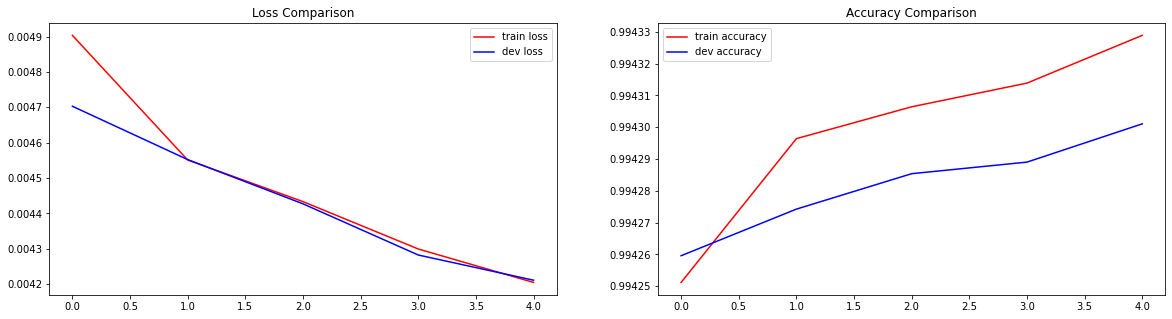

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
plt.show()

### View Predicted Segmentations

In [290]:
unet.load_weights("./saved_line_model/best_model.hdf5")

In [66]:
def plotResult(n, fileName):
    test_dataset = tf.data.Dataset.from_tensor_slices([fileName])
    test_dataset = test_dataset.map(load_img)
    test_dataset = test_dataset.batch(1)

    predicted = unet.predict(test_dataset)
    mapName = 'map_patches/'+fileName
    segName = 'seg_patches/'+fileName

    map_img = mpimg.imread(filePath+mapName)
    seg_img = mpimg.imread(filePath+segName)
    
    labelName = 'labels/'+fileName
    label_img = mpimg.imread(filePath+labelName)
    
    plt.rcParams["figure.figsize"] = (25,10)
    
    plt.subplot(n,5,1)
    plt.title("map")
    plt.imshow(map_img)

    plt.subplot(n,5,2)
    plt.title("legend")
    plt.imshow(label_img)

    plt.subplot(n,5,3)
    plt.title("true segmentation")
    plt.spy(seg_img, markersize=1) 

    plt.subplot(n,5,4)
    plt.title("predicted segmentation")
    predicted[predicted >= 0.5] = 1
    predicted[predicted < 0.5] = 0
    plt.spy(predicted[0,:,:,0], markersize=1) 

    plt.subplot(n,5,5)
    plt.title("error")
    plt.spy(predicted[0,:,:,0]-seg_img, markersize=1) 
    plt.show()

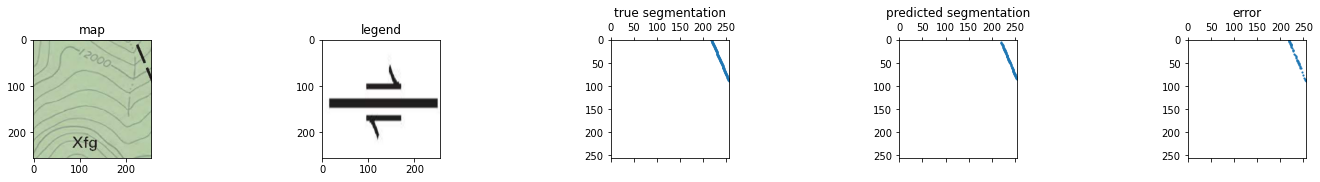

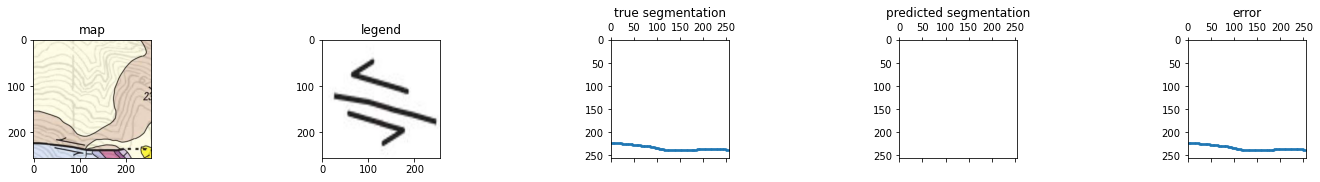

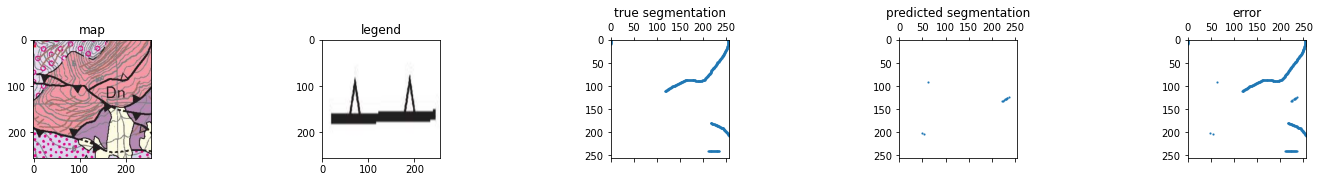

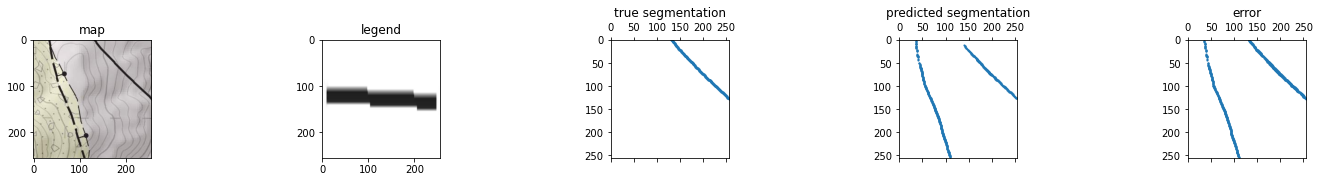

In [71]:
n=4
for fileName in random.sample(validate_file, n):
    # fileName.split('.')[0].split('_')[-2]
    plotResult(n, fileName)

In [ ]:
# from customized_metrics import feature_f_score
# precision, recall, f_score = feature_f_score(map_image_path, predicted_raster_path, true_raster_path, legend_json_path=None, min_valid_range=.25,
#                       difficult_weight=.7, set_false_as='hard', plot=False)